# Pre-trained Vectors -  Toxic Comments

A corpus of manually labeled comments - classifying each comment by its type of toxicity is available on Kaggle. We will aim to do a binary classification of whether a comment is toxic or not.

Approach:
- Use a Pre-Trained Embedding from Spacy (Other options are Glove, FastText or Word2vec)
- Use 1D-CNN to model the sequence 

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

Using TensorFlow backend.


### Get the Data

Uncomment these shell lines to get the data

In [2]:
#!wget http://bit.do/deep_toxic_train -P data/
#!mv data/deep_toxic_train data/train.zip

In [3]:
df = pd.read_csv("data/train.zip")

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Import the required libraries

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Create the Input & Output Data

In [6]:
train_sentences = df["comment_text"]
train_sentences.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

**Pre-processing the train data**
- Tokenization: "This is an apple" -> ["This", "is", "an", "apple"]
- Indexing: {0: "This", 1: "is", 2: "an", 3: "apple"}
- Index Representation: [0, 1, 2, 3]

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
# Tokenizer
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK')
tokenizer.fit_on_texts(list(train_sentences))

Tokenizer Fix from https://github.com/keras-team/keras/issues/8092

In [9]:
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1

In [10]:
# Index Representation
tokenized_train = tokenizer.texts_to_sequences(train_sentences)

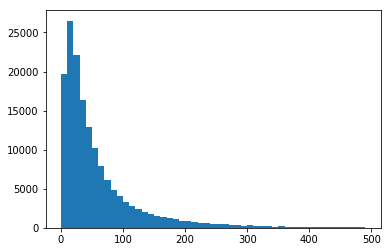

In [11]:
# Selecting Padding
# find length of each sentence and plot the length
number_of_words = [len(comment) for comment in tokenized_train]
plt.hist(number_of_words, bins = np.arange(0, 500, 10));

In [12]:
# Padding to make it uniform
maxlen = 200
X = pad_sequences(tokenized_train, maxlen = maxlen)

In [13]:
labels = df.iloc[:,2].values

In [14]:
# Baseline Benchmark 
1 - df.iloc[:,2].sum()/df.iloc[:,2].count()

0.9041555169799024

In [15]:
from keras.utils import to_categorical
y = to_categorical(labels)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127656, 200), (31915, 200), (127656, 2), (31915, 2))

### Step 1a: Creating pre-trained Embedding

In [18]:
import spacy

In [22]:
#!python -m spacy download en_core_web_md

In [23]:
nlp = spacy.load('en_core_web_md')

A word vector from spacy can be called on any word 

In [24]:
doc = nlp("Hello")
doc.vector.shape

(300,)

In [25]:
tokenizer.num_words

20000

Creating the Embedding Matrix

In [26]:
embedding_dim = 300
word_index = tokenizer.word_index

In [30]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = nlp(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(20002, 300)

In [33]:
len(word_index)

20001

### Step 2: Create the Model Architecture

In [36]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [37]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
model.add(Conv1D(128, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation='sigmoid'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          6000600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 194, 128)          268928    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total para

### Step 3: Compile the Model & Fit on the Data

In [40]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
output = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 32s 313us/step - loss: 0.1759 - acc: 0.9388 - val_loss: 0.1537 - val_acc: 0.9465
Epoch 2/5
102124/102124 [==============================] - 31s 304us/step - loss: 0.1438 - acc: 0.9487 - val_loss: 0.1514 - val_acc: 0.9470
Epoch 3/5
102124/102124 [==============================] - 31s 302us/step - loss: 0.1263 - acc: 0.9543 - val_loss: 0.1652 - val_acc: 0.9415
Epoch 4/5
102124/102124 [==============================] - 31s 302us/step - loss: 0.1072 - acc: 0.9608 - val_loss: 0.1717 - val_acc: 0.9425
Epoch 5/5
102124/102124 [==============================] - 30s 298us/step - loss: 0.0889 - acc: 0.9676 - val_loss: 0.1748 - val_acc: 0.9455


### Step 4: Evaluate the Model

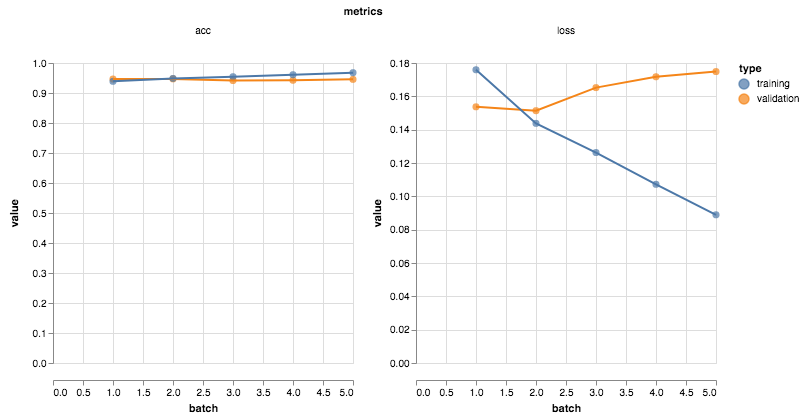

In [42]:
vis.metrics(output.history)

In [43]:
score = model.evaluate(X_test, y_test, verbose=1)

31915/31915 [==============================] - 5s 161us/step


In [44]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18175359526685594
Test accuracy: 0.9437881873727088


### Step 5: Visualise evaluation & Make a prediction

In [45]:
predict_classes = model.predict_classes(X_test)

In [47]:
actual_classes = np.dot(y_test,np.array([[0],[1]])).reshape(-1)

In [48]:
pd.crosstab(actual_classes, predict_classes)

col_0,0,1
row_0,,
0.0,28320,539
1.0,1258,1798
